# Overview
This script takes in an image and returns a list of instructions for the robot to execute.

In [2]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy import stats
!pip install imutils
import imutils
from math import pi
import queue

# Helper Code
To detect central square for calibration purposes

In [124]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def get_side(sq, i):
    return ((sq[i][0] - sq[(i+1)%4][0])**2 + (sq[i][1] - sq[(i+1)%4][1])**2)**0.5

def find_squares(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv2.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, None)
            else:
                _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, _hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    #print(cnt)
                    a = (cnt[1][1] - cnt[0][1])

                    if max_cos < 0.1 and a < img.shape[0]*0.8:

                        squares.append(cnt)
    return squares

def sqsize(img):
    sqlist = find_squares(img)
    oksides = []
    for sq in sqlist:
        sides = [get_side(sq, i) for i in range(4)]
        if (max(sides) / min(sides) > 1.2):
            continue
        oksides.append(round(np.mean(sides)))
    oksides = sorted(oksides)
    return oksides[-3]

# Pathfinder
Approach: 

1. Rotate the image to be aligned with the axes

2. Find the equivalent length of a pixel

3. Detect contours in image - these are obstacles

4. Block out all areas within a radius of these obstacles to prevent collision

5. Pathfind from S to E using Dijkstra's algorithm


In [195]:
class PathFinder:
    def __init__(self, imagename):
        self.img = cv2.imread(imagename)
        self.img_contours = None
        self.processed = None
        self.dx = (-1,0,0,1)
        self.dy = (0,-1,1,0)
        self.theta = 0
        
    def display(self):
        print("Displaying original image, image contours and processed image")
        plt.imshow(self.img)
        plt.figure()
        plt.imshow(self.img_contours)
        plt.figure()
        plt.imshow(self.processed)
        plt.figure()
        
    def rotate(self, hough_thr):
        #rotates images based on mode angle of detected lines
        gray_img = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        #50 and 100 represent two thresholds
        #see https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny
        edges = cv2.Canny(gray_img,50,150,apertureSize = 3)
        lines = cv2.HoughLines(edges,1,np.pi/180,hough_thr)
        angles = []
        for line in lines:
            for rho,theta in line:
                #print(theta)
                if (theta < pi/4 or pi - theta < pi/4):
                    if theta > pi/2: angles.append(round(theta - pi, 2))
                    else: angles.append(round(theta, 2))
                    
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))
                cv2.line(gray_img,(x1,y1),(x2,y2),255,2)
        '''
        mode_angle = stats.mode(np.array(angles))[0] * 180 / pi
        #print(mode_angle)
        if (mode_angle > 90): mode_angle -= 180
        self.img = imutils.rotate_bound(self.img, -mode_angle)
        self.theta = mode_angle
        '''
        #print(angles)
        mean_angle = np.mean(np.array(angles)) * 180 / pi
        self.img = imutils.rotate_bound(self.img, -mean_angle)
        self.theta = mean_angle
    
    def calibrate(self):
        self.pixel = 44/sqsize(self.img)
        return self.pixel

    def get_contours(self, channel, contour_thr):
        img_chan = self.img[:,:,channel]
        ret,thresh_img = cv2.threshold(img_chan, contour_thr, 255, cv2.THRESH_BINARY)
        contours = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
        return contours
    
    def draw_contours(self):
        self.img_contours = np.zeros(self.img.shape[:2])
        cv2.drawContours(self.img_contours, self.get_contours(0, 220), -1, 1, 3)
        cv2.drawContours(self.img_contours, self.get_contours(1, 220), -1, 1, 3)
        cv2.drawContours(self.img_contours, self.get_contours(2, 220), -1, 1, 3)
        
    def expand(self, radius):
        #radius is the number of pixels occupied by the half length of the robot
        self.processed = np.zeros(self.img.shape[:2])
        height = self.img.shape[0]
        width = self.img.shape[1]
        for x in range(height):
            for y in range(width):
                if self.img_contours[x,y]==0: continue
                self.processed[max(x-radius,0):min(x+radius,height), max(y-radius,0):min(y+radius,width)] = 1
    
    def genDistFromWalls(self):
        xmax,ymax = self.processed.shape
        dist = np.full(self.processed.shape,-1)
        prev = np.full(self.processed.shape+(2,),-1)
        q = queue.Queue()
        for x in range(xmax):
            for y in range(ymax):
                if self.processed[x][y] == 1: #Colour of wall
                    dist[x][y] = 0
                    q.put((x,y))

        while not q.empty():
            x,y = q.get()
            for i in range(4):
                nx,ny = x+self.dx[i], y+self.dy[i]
                if nx<0 or nx>=xmax or ny<0 or ny>=ymax:
                    continue
                if dist[nx][ny] != -1:
                    continue
                dist[nx][ny] = dist[x][y]+1
                prev[nx][ny] = (x,y)
                q.put((nx,ny))
        return dist
    
    def dijkstra(self, start, end, edge_weight=lambda x,y:1000/x):
        self.start = start
        self.end = end
        xmax,ymax = self.processed.shape
        xstart,ystart = start
        xend,yend = end
        assert(self.processed[xstart][ystart] == 0)
        assert(self.processed[xend][yend] == 0)
        dist_walls=self.genDistFromWalls()

        dist = np.full(self.processed.shape,-1.0)
        prev = np.full(self.processed.shape+(2,),-1)
        
        q = queue.PriorityQueue()
        dist[xstart][ystart] = 0
        q.put((0,xstart,ystart))

        while not q.empty():
            d,x,y = q.get()
            if d != dist[x][y]:
                continue
            for i in range(4):
                nx,ny = x+self.dx[i], y+self.dy[i]
                if nx<0 or nx>=xmax or ny<0 or ny>=ymax:
                    continue
                if self.processed[nx][ny] != self.processed[xstart][ystart]:
                    continue
                nd = d+1+edge_weight(dist_walls[nx][ny], tuple(prev[x][y]) == (x-self.dx[i],y-self.dy[i]))
                if dist[nx][ny] == -1 or dist[nx][ny] > nd:
                    dist[nx][ny] = nd
                    prev[nx][ny] = (x,y)
                    q.put((nd,nx,ny))

        path = [(xend,yend)]
        while path[-1] != (xstart,ystart):
            if path[-1] == (-1,-1):
                print("No path found!")
                break
            x,y = path[-1]
            path.append(tuple(prev[x][y]))
        path.reverse()
        
        self.dist, self.prev, self.path = dist,prev,path
    
    def plot_path(self):
        xstart,ystart = self.start
        xend,yend = self.end

        plt.imshow(self.dist, cmap='hot', interpolation='nearest')
        plt.text(ystart,xstart,'S',color='g',bbox=dict(fill=False, edgecolor='green', linewidth=2))
        plt.text(yend,xend,'E',color='b',bbox=dict(fill=False, edgecolor='blue', linewidth=2))

        x,y = list(zip(*self.path))
        plt.scatter(y,x,s=1,c='purple')

        plt.show()
    
    def gen_instructions(self):
        instructions = [[self.path[0], np.subtract(self.path[1], self.path[0])]]
        for i in range(1,len(self.path)-1):
            prev, cur, nxt = self.path[i-1], self.path[i], self.path[i+1]
            if (np.array_equal(np.subtract(cur, prev), np.subtract(nxt, cur)) == False):
                instructions.append([cur, np.subtract(nxt, cur)])
        instructions.append([self.end, None])
        for i in range(len(instructions) - 1):
            dist = np.abs(instructions[i+1][0][0] - instructions[i][0][0]) + np.abs(instructions[i+1][0][1] - instructions[i][0][1])
            instructions[i].append(dist)
        return instructions

    def robot_instruct(self):
        verbose = self.gen_instructions()
        pruned = []
        # move 25 to enter S
        pruned.append([0, 25])
        # instruction (x, y) means move right x, move up y
        for command in verbose:
            if (len (command) < 3): continue
            dist = command[2] * self.pixel
            pruned.append([command[1][1] * dist, -command[1][0] * dist])
        # move 20 forwards to exit E
        pruned.append([0, 20])
        return pruned
        

1.4660766
1.4660766
1.4660766
3.1241393
1.4660766
1.4660766
3.0019662
0.0
1.4486233
0.0
2.9670596
3.0019662
1.4486233
1.4486233
2.9146998
3.0892327
1.4486233
1.4486233
1.4486233
1.4835298
[-0.02, -0.14, 0.0, 0.0, -0.17, -0.14, -0.23, -0.05]
147.0
Displaying original image, image contours and processed image


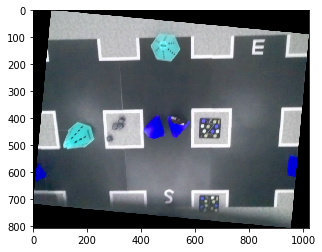

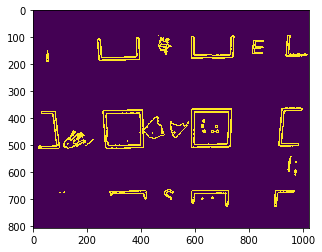

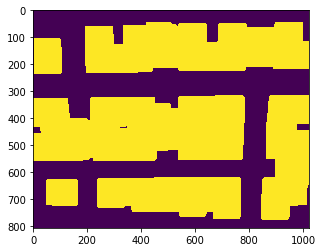

<Figure size 432x288 with 0 Axes>

In [211]:
solver = PathFinder("Drone Images/Arena images/6.jpg")
solver.rotate(100)
# 44 cm is the width of the central square 
solver.calibrate()
#This is the number of pixels occupied by side length
print(44/solver.pixel)
solver.draw_contours()
#this value is dependent on the pixel width
#14 cm is the half width of the robot
solver.expand(int(14 / solver.pixel))
solver.display()

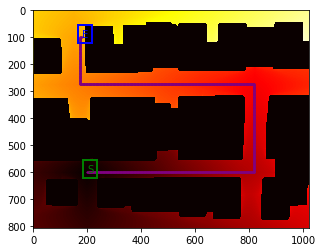

In [212]:
solver.dijkstra((600, 200), (100, 180), lambda x,y:100/x*(0.20 if y else 1))
#1000 and 0.20 can be tuned
solver.plot_path()

In [213]:
#generates a list of coordinates, directions and distances
solver.gen_instructions()
#generates translation instructions for the robot

solver.robot_instruct()

[[184.9795918367347, 0.0],
 [0.0, 98.17687074829932],
 [-192.76190476190476, 0.0],
 [0.0, 51.48299319727891],
 [1.7959183673469388, 0.0],
 [0, 20]]